# 06 — RLHF from Scratch: Teach the Model What "Good" Means

SFT taught our model *format* (how to respond to instructions), but not *quality* (which responses are better than others). Every training example was treated equally.

**RLHF** (Reinforcement Learning from Human Feedback) closes this gap in two steps:
1. **Reward Model** — a neural network trained on human preferences ("response A is better than B") that learns to score responses
2. **PPO (Proximal Policy Optimization)** — an RL algorithm that pushes the language model toward higher-reward responses, with a KL penalty to prevent it from going off the rails

In this notebook we'll build both from scratch.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import copy

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')
torch.manual_seed(1337)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/vallari/src/llm-from-first-principles/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/vallari/src/llm-from-first-principles/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/vallari/src/llm-from-first-principles/venv/lib/python3.11/site-packages/ipykern

Using device: cpu


## Part 0: Rebuild the SFT Model

We need a trained SFT model as our starting point. This repeats the key parts of notebook 05.

In [2]:
# Load data and build vocabulary (same as notebook 05)
with open('../data/shakespeare/input.txt', 'r') as f:
    text = f.read()

chars = sorted(list(set(text)))
base_vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Special tokens
SPECIAL_TOKENS = {
    '<|user|>': base_vocab_size,
    '<|assistant|>': base_vocab_size + 1,
    '<|end|>': base_vocab_size + 2,
}
ID_TO_SPECIAL = {v: k for k, v in SPECIAL_TOKENS.items()}
sft_vocab_size = base_vocab_size + len(SPECIAL_TOKENS)

def encode_sft(text):
    tokens = []
    i = 0
    while i < len(text):
        matched = False
        for token_str, token_id in SPECIAL_TOKENS.items():
            if text[i:].startswith(token_str):
                tokens.append(token_id)
                i += len(token_str)
                matched = True
                break
        if not matched:
            tokens.append(stoi[text[i]])
            i += 1
    return tokens

def decode_sft(tokens):
    result = []
    for t in tokens:
        if t in ID_TO_SPECIAL:
            result.append(ID_TO_SPECIAL[t])
        else:
            result.append(itos[t])
    return ''.join(result)

print(f'Vocab: {base_vocab_size} base + 3 special = {sft_vocab_size}')

Vocab: 65 base + 3 special = 68


In [3]:
# Hyperparameters and model architecture
batch_size = 32
block_size = 64
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        return wei @ self.value(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), nn.Dropout(dropout))

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.sa = MultiHeadAttention(n_head, n_embd // n_head)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            return logits, None
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

print(f'Model architecture defined.')

Model architecture defined.


In [4]:
# Pre-train base model on Shakespeare
def get_batch(split):
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

base_model = GPT(base_vocab_size).to(device)
optimizer = torch.optim.AdamW(base_model.parameters(), lr=3e-4)

print("Pre-training base model...")
for iter in range(3000):
    if iter % 1000 == 0:
        base_model.eval()
        losses = torch.zeros(200)
        for k in range(200):
            X, Y = get_batch('val')
            _, loss = base_model(X, Y)
            losses[k] = loss.item()
        print(f"  step {iter}: val loss {losses.mean():.4f}")
        base_model.train()
    xb, yb = get_batch('train')
    _, loss = base_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print("Pre-training done.")

Pre-training base model...
  step 0: val loss 4.3473
  step 1000: val loss 2.4010
  step 2000: val loss 2.2308
Pre-training done.


In [5]:
# SFT on conversation data
conversations = [
    ("Write a greeting", "Good morrow to thee, noble friend!"),
    ("Say hello", "Hail and well met, good sir!"),
    ("Greet a friend", "Welcome, dear companion of mine heart!"),
    ("Say goodbye", "Farewell, and may fortune smile upon thee."),
    ("Write a farewell", "Good night, sweet friend, till we meet again."),
    ("Who are you", "A humble player upon this stage of words."),
    ("Speak of love", "Love is a smoke raised with the fume of sighs."),
    ("Tell me of love", "It is the star to every wandering bark."),
    ("What is love", "A madness most discreet, a bitter sweet."),
    ("What is honor", "Honor is a mere word, yet it moves the heart."),
    ("Speak of duty", "Duty binds us all, from king to common man."),
    ("Describe the night", "The moon doth hang like silver in the sky."),
    ("Write of morning", "Dawn breaks golden upon the sleeping earth."),
    ("Give me counsel", "Be wise, be patient, and trust thy heart."),
    ("Give advice", "Think well before thou speak, and speak the truth."),
    ("What should I do", "Follow the path that honor bids thee walk."),
    ("Tell me a story", "Once there lived a king both wise and bold."),
    ("I am sad", "Take heart, for sorrow fades as morning comes."),
    ("I am afraid", "Fear not, for courage lives within thy soul."),
    ("Write a line of verse", "Shall I compare thee to a summer day?"),
    ("Give a toast", "To health and joy, and friends both old and new!"),
    ("Say something kind", "Thou art more lovely than the fairest dawn."),
    ("Cheer me up", "Smile, for the world is bright and full of wonder."),
]

def prepare_sft_example(user_msg, asst_msg, max_len=block_size):
    text = f"<|user|>{user_msg}<|end|><|assistant|>{asst_msg}<|end|>"
    tokens = encode_sft(text)
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    pad_len = max_len - len(tokens)
    tokens = tokens + [0] * pad_len
    input_ids = tokens[:-1]
    labels = tokens[1:]

    asst_token_id = SPECIAL_TOKENS['<|assistant|>']
    asst_pos = None
    for i, t in enumerate(input_ids):
        if t == asst_token_id:
            asst_pos = i
            break

    masked_labels = []
    for i, t in enumerate(labels):
        if asst_pos is not None and i <= asst_pos:
            masked_labels.append(-100)
        elif i >= (max_len - 1 - pad_len):
            masked_labels.append(-100)
        else:
            masked_labels.append(t)
    return input_ids, masked_labels

# Build SFT model from pre-trained weights
sft_model = GPT(sft_vocab_size).to(device)
pretrained_state = base_model.state_dict()
sft_state = sft_model.state_dict()
for key in pretrained_state:
    if key in sft_state:
        if pretrained_state[key].shape == sft_state[key].shape:
            sft_state[key] = pretrained_state[key]
        elif 'token_embedding' in key:
            sft_state[key][:base_vocab_size] = pretrained_state[key]
        elif 'lm_head.weight' in key:
            sft_state[key][:base_vocab_size] = pretrained_state[key]
        elif 'lm_head.bias' in key:
            sft_state[key][:base_vocab_size] = pretrained_state[key]
sft_model.load_state_dict(sft_state)

# Prepare SFT data
all_input_ids, all_labels = [], []
for user_msg, asst_msg in conversations:
    input_ids, labels = prepare_sft_example(user_msg, asst_msg)
    all_input_ids.append(input_ids)
    all_labels.append(labels)

sft_input_ids = torch.tensor(all_input_ids, dtype=torch.long, device=device)
sft_labels = torch.tensor(all_labels, dtype=torch.long, device=device)

# Train SFT
optimizer = torch.optim.AdamW(sft_model.parameters(), lr=1e-4)
print("SFT training...")
sft_model.train()
for iter in range(1000):
    batch_idx = torch.randint(len(sft_input_ids), (8,))
    xb = sft_input_ids[batch_idx]
    yb = sft_labels[batch_idx]
    logits, _ = sft_model(xb)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T), ignore_index=-100)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if iter % 200 == 0:
        print(f"  step {iter}: SFT loss {loss.item():.4f}")

print("SFT done. We now have our instruction-following model.")

SFT training...
  step 0: SFT loss 2.2941
  step 200: SFT loss 1.4508
  step 400: SFT loss 1.0898
  step 600: SFT loss 0.8168
  step 800: SFT loss 0.5606
SFT done. We now have our instruction-following model.


In [6]:
# Quick sanity check: the SFT model can follow instructions
def chat(model, user_msg, max_tokens=50):
    prompt = f"<|user|>{user_msg}<|end|><|assistant|>"
    tokens = encode_sft(prompt)
    idx = torch.tensor([tokens], dtype=torch.long, device=device)
    model.eval()
    with torch.no_grad():
        output = model.generate(idx, max_new_tokens=max_tokens)[0].tolist()
    model.train()
    full_text = decode_sft(output)
    if '<|assistant|>' in full_text:
        response = full_text.split('<|assistant|>')[-1]
        if '<|end|>' in response:
            response = response.split('<|end|>')[0]
        return response.strip()
    return full_text

print("SFT model responses:")
for prompt in ["Write a greeting", "Speak of love", "Give advice"]:
    print(f"  User: {prompt}")
    print(f"  Asst: {chat(sft_model, prompt)}")

SFT model responses:
  User: Write a greeting
  Asst: or wor smer sweare.
  User: Speak of love
  Asst: ompor ind spis to thee!
  User: Give advice
  Asst: othe nothe a nd pathert, and trust thee low thing


## Part 1: The Reward Model

The reward model learns to score responses based on human preferences. It's trained on **preference pairs**: for the same prompt, humans say "response A is better than response B."

Architecture: same as the language model, but instead of predicting the next token, it outputs a **single scalar score** for the whole sequence. We take the last token's hidden state and project it to a scalar.

Training objective (**Bradley-Terry model**):

$$\mathcal{L} = -\log \sigma(r_\text{chosen} - r_\text{rejected})$$

This loss pushes `r_chosen > r_rejected` — the reward model should score the preferred response higher.

In [7]:
# Preference dataset: (prompt, chosen_response, rejected_response)
#
# "Chosen" = the response a human would prefer
# "Rejected" = a worse alternative
#
# In practice, these come from human annotators ranking model outputs.
# We create them by hand to demonstrate the concept.

preference_data = [
    # (prompt, chosen, rejected)
    # Chosen responses are helpful, poetic, on-topic
    # Rejected responses are off-topic, rude, or low-quality
    ("Write a greeting",
     "Good morrow to thee, noble friend!",
     "What dost thou want of me now?"),
    ("Say hello",
     "Hail and well met, good sir!",
     "Go away, I have no time."),
    ("Speak of love",
     "Love is a smoke raised with the fume of sighs.",
     "I know not of love nor care."),
    ("What is love",
     "A madness most discreet, a bitter sweet.",
     "It matters not. Ask another."),
    ("Give me counsel",
     "Be wise, be patient, and trust thy heart.",
     "Do what thou wilt, it matters not."),
    ("Give advice",
     "Think well before thou speak, and speak the truth.",
     "I care not for thy troubles."),
    ("I am sad",
     "Take heart, for sorrow fades as morning comes.",
     "Then be sad. What can I do?"),
    ("I am afraid",
     "Fear not, for courage lives within thy soul.",
     "Thou shouldst be afraid, fool."),
    ("Tell me a story",
     "Once there lived a king both wise and bold.",
     "No. I shall not. Leave me be."),
    ("Say goodbye",
     "Farewell, and may fortune smile upon thee.",
     "Good riddance to thee then."),
    ("Write a farewell",
     "Good night, sweet friend, till we meet again.",
     "Be gone from my sight at once."),
    ("Who are you",
     "A humble player upon this stage of words.",
     "None of thy concern, stranger."),
    ("Describe the night",
     "The moon doth hang like silver in the sky.",
     "It is dark. What more to say?"),
    ("Write of morning",
     "Dawn breaks golden upon the sleeping earth.",
     "Morning comes as always it does."),
    ("What should I do",
     "Follow the path that honor bids thee walk.",
     "How should I know? Decide thyself."),
    ("Give a toast",
     "To health and joy, and friends both old and new!",
     "Drink and be done with it."),
    ("Say something kind",
     "Thou art more lovely than the fairest dawn.",
     "Thou art adequate, I suppose."),
    ("Cheer me up",
     "Smile, for the world is bright and full of wonder.",
     "Why should I cheer thee? Cheer thyself."),
]

print(f"Preference dataset: {len(preference_data)} examples")
print(f"\nExample:")
print(f"  Prompt:   {preference_data[0][0]}")
print(f"  Chosen:   {preference_data[0][1]}")
print(f"  Rejected: {preference_data[0][2]}")

Preference dataset: 18 examples

Example:
  Prompt:   Write a greeting
  Chosen:   Good morrow to thee, noble friend!
  Rejected: What dost thou want of me now?


In [8]:
# The Reward Model
#
# Same transformer backbone as the language model, but the output head
# maps to a SINGLE SCALAR instead of vocab_size logits.
# We take the hidden state of the LAST token and project it to a score.

class RewardModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.reward_head = nn.Linear(n_embd, 1)  # scalar output

    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        # Take the LAST token's hidden state as the sequence representation
        # (like using [CLS] token or mean pooling, but simpler)
        last_hidden = x[:, -1, :]  # (B, n_embd)
        reward = self.reward_head(last_hidden)  # (B, 1)
        return reward.squeeze(-1)  # (B,)

# Initialize reward model from SFT weights (transfer learning)
reward_model = RewardModel(sft_vocab_size).to(device)

# Copy shared weights from SFT model
sft_state = sft_model.state_dict()
rm_state = reward_model.state_dict()
for key in rm_state:
    if key in sft_state and rm_state[key].shape == sft_state[key].shape:
        rm_state[key] = sft_state[key]
reward_model.load_state_dict(rm_state)

print(f"Reward model: {sum(p.numel() for p in reward_model.parameters()):,} params")
print(f"Output: single scalar score per sequence")

Reward model: 207,809 params
Output: single scalar score per sequence


In [9]:
# Prepare preference data for reward model training
def encode_for_reward(prompt, response, max_len=block_size):
    """Encode a (prompt, response) as a full chat sequence for the reward model."""
    text = f"<|user|>{prompt}<|end|><|assistant|>{response}<|end|>"
    tokens = encode_sft(text)
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    # Pad
    pad_len = max_len - len(tokens)
    tokens = tokens + [0] * pad_len
    return tokens

chosen_ids = []
rejected_ids = []
for prompt, chosen, rejected in preference_data:
    chosen_ids.append(encode_for_reward(prompt, chosen))
    rejected_ids.append(encode_for_reward(prompt, rejected))

chosen_tensor = torch.tensor(chosen_ids, dtype=torch.long, device=device)
rejected_tensor = torch.tensor(rejected_ids, dtype=torch.long, device=device)

print(f"Chosen shape: {chosen_tensor.shape}")
print(f"Rejected shape: {rejected_tensor.shape}")

Chosen shape: torch.Size([18, 64])
Rejected shape: torch.Size([18, 64])


In [10]:
# Train the reward model
#
# Loss: -log(sigmoid(r_chosen - r_rejected))
# This is the Bradley-Terry model: it learns to assign higher scores
# to preferred responses.

rm_optimizer = torch.optim.AdamW(reward_model.parameters(), lr=1e-4)
rm_losses = []
rm_accuracies = []

print("Training reward model...")
reward_model.train()
for iter in range(500):
    # Sample a batch
    batch_idx = torch.randint(len(chosen_tensor), (8,))
    chosen_batch = chosen_tensor[batch_idx]
    rejected_batch = rejected_tensor[batch_idx]

    # Forward pass: get scores for both chosen and rejected
    r_chosen = reward_model(chosen_batch)    # (B,)
    r_rejected = reward_model(rejected_batch) # (B,)

    # Bradley-Terry loss: -log(sigmoid(r_chosen - r_rejected))
    loss = -F.logsigmoid(r_chosen - r_rejected).mean()

    rm_optimizer.zero_grad(set_to_none=True)
    loss.backward()
    rm_optimizer.step()

    # Track accuracy: how often does the model rank chosen > rejected?
    accuracy = (r_chosen > r_rejected).float().mean().item()
    rm_losses.append(loss.item())
    rm_accuracies.append(accuracy)

    if iter % 100 == 0:
        print(f"  step {iter}: loss {loss.item():.4f}, accuracy {accuracy:.2f}")

print(f"\nFinal: loss {rm_losses[-1]:.4f}, accuracy {rm_accuracies[-1]:.2f}")

Training reward model...
  step 0: loss 0.4877, accuracy 0.88
  step 100: loss 0.0684, accuracy 1.00
  step 200: loss 0.0034, accuracy 1.00
  step 300: loss 0.0005, accuracy 1.00
  step 400: loss 0.0003, accuracy 1.00

Final: loss 0.0003, accuracy 1.00


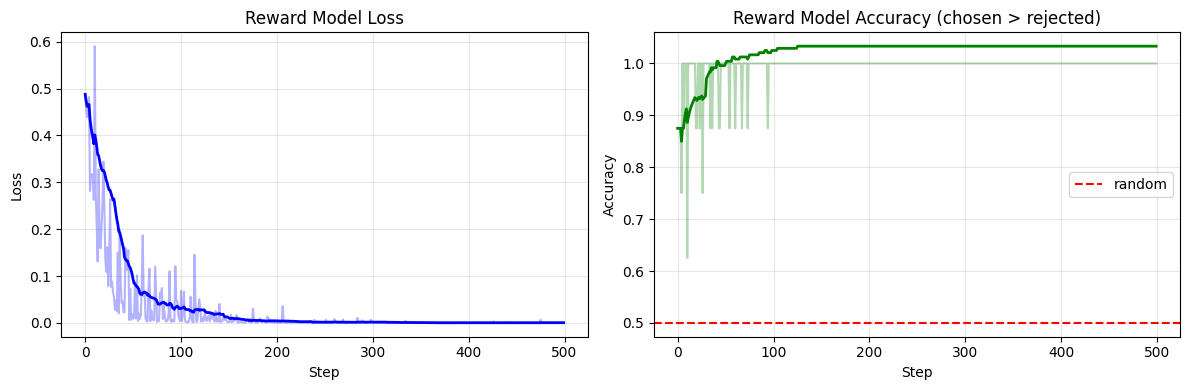

In [11]:
# Plot reward model training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(rm_losses, alpha=0.3, color='blue')
window = 30
smoothed = [sum(rm_losses[max(0,i-window):i+1])/min(i+1,window) for i in range(len(rm_losses))]
ax1.plot(smoothed, color='blue', linewidth=2)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Reward Model Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(rm_accuracies, alpha=0.3, color='green')
smoothed_acc = [sum(rm_accuracies[max(0,i-window):i+1])/min(i+1,window) for i in range(len(rm_accuracies))]
ax2.plot(smoothed_acc, color='green', linewidth=2)
ax2.axhline(y=0.5, color='red', linestyle='--', label='random')
ax2.set_xlabel('Step')
ax2.set_ylabel('Accuracy')
ax2.set_title('Reward Model Accuracy (chosen > rejected)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Verify: does the reward model actually prefer good responses?
reward_model.eval()
print("Reward model scores on held-out examples:")
print("(higher = better, the model should score 'chosen' higher)\n")

with torch.no_grad():
    for prompt, chosen, rejected in preference_data[:6]:
        c_tokens = torch.tensor([encode_for_reward(prompt, chosen)], dtype=torch.long, device=device)
        r_tokens = torch.tensor([encode_for_reward(prompt, rejected)], dtype=torch.long, device=device)
        c_score = reward_model(c_tokens).item()
        r_score = reward_model(r_tokens).item()
        winner = 'CORRECT' if c_score > r_score else 'WRONG'
        print(f"  Prompt: '{prompt}'")
        print(f"    Chosen:   {c_score:+.3f}  '{chosen[:40]}...'")
        print(f"    Rejected: {r_score:+.3f}  '{rejected[:40]}...'")
        print(f"    → {winner}")
        print()

Reward model scores on held-out examples:
(higher = better, the model should score 'chosen' higher)

  Prompt: 'Write a greeting'
    Chosen:   +4.344  'Good morrow to thee, noble friend!...'
    Rejected: -5.577  'What dost thou want of me now?...'
    → CORRECT

  Prompt: 'Say hello'
    Chosen:   +3.389  'Hail and well met, good sir!...'
    Rejected: -5.590  'Go away, I have no time....'
    → CORRECT

  Prompt: 'Speak of love'
    Chosen:   +4.732  'Love is a smoke raised with the fume of ...'
    Rejected: -5.367  'I know not of love nor care....'
    → CORRECT

  Prompt: 'What is love'
    Chosen:   +4.689  'A madness most discreet, a bitter sweet....'
    Rejected: -5.585  'It matters not. Ask another....'
    → CORRECT

  Prompt: 'Give me counsel'
    Chosen:   +4.857  'Be wise, be patient, and trust thy heart...'
    Rejected: -5.225  'Do what thou wilt, it matters not....'
    → CORRECT

  Prompt: 'Give advice'
    Chosen:   +5.133  'Think well before thou speak, and speak .

## Part 2: PPO — Reinforcement Learning on Language

Now we use the reward model to improve the language model. The idea:

1. **Generate** a response from the current policy (our language model)
2. **Score** it with the reward model
3. **Update** the policy to make high-reward responses more likely

But there's a catch: without constraints, the model will find **reward hacking** shortcuts — generating gibberish that scores high on the reward model but isn't actually good. 

The fix: a **KL divergence penalty** that keeps the RL-trained model close to the SFT model.

$$\text{objective} = \mathbb{E}[r(x, y)] - \beta \cdot D_{KL}(\pi_\theta \| \pi_{\text{SFT}})$$

- First term: maximize reward
- Second term: don't drift too far from SFT (the "anchor")
- $\beta$: controls the trade-off (higher = stay closer to SFT)

In [13]:
# The PPO setup:
# - policy_model: the model we're optimizing (starts as a copy of SFT model)
# - ref_model: frozen copy of SFT model (for KL penalty)
# - reward_model: the trained reward model (frozen)

# Clone SFT model as our starting policy
policy_model = GPT(sft_vocab_size).to(device)
policy_model.load_state_dict(sft_model.state_dict())

# Freeze a reference copy (for KL divergence)
ref_model = GPT(sft_vocab_size).to(device)
ref_model.load_state_dict(sft_model.state_dict())
ref_model.eval()
for p in ref_model.parameters():
    p.requires_grad = False

# Freeze reward model
reward_model.eval()
for p in reward_model.parameters():
    p.requires_grad = False

print("PPO setup:")
print(f"  Policy model: {sum(p.numel() for p in policy_model.parameters()):,} params (trainable)")
print(f"  Ref model:    frozen copy of SFT model")
print(f"  Reward model: frozen")

PPO setup:
  Policy model: 212,164 params (trainable)
  Ref model:    frozen copy of SFT model
  Reward model: frozen


In [14]:
# PPO helper functions

def get_log_probs(model, input_ids, generated_ids):
    """Get log probabilities of generated tokens under a model."""
    # Combine prompt + generated for full sequence
    full_ids = torch.cat([input_ids, generated_ids], dim=1)
    # We need logits for positions where generation happened
    full_ids = full_ids[:, :block_size]  # truncate to block_size
    logits, _ = model(full_ids)
    # Get log probs for the generated portion
    prompt_len = input_ids.shape[1]
    gen_len = min(generated_ids.shape[1], block_size - prompt_len)
    if gen_len <= 0:
        return torch.zeros(input_ids.shape[0], device=device)

    # logits at position t predict token at position t+1
    # So logits[prompt_len-1 : prompt_len-1+gen_len] predict generated_ids[0:gen_len]
    relevant_logits = logits[:, prompt_len-1:prompt_len-1+gen_len, :]  # (B, gen_len, vocab)
    relevant_targets = generated_ids[:, :gen_len]  # (B, gen_len)

    log_probs = F.log_softmax(relevant_logits, dim=-1)  # (B, gen_len, vocab)
    # Gather the log probs of the actual tokens
    token_log_probs = log_probs.gather(2, relevant_targets.unsqueeze(-1)).squeeze(-1)  # (B, gen_len)
    # Sum over sequence length for total log prob
    return token_log_probs.sum(dim=-1)  # (B,)

def generate_response(model, prompt_ids, max_new_tokens=30):
    """Generate a response from the model given prompt token IDs."""
    model.eval()
    generated = []
    idx = prompt_ids.clone()
    end_token = SPECIAL_TOKENS['<|end|>']
    with torch.no_grad():
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = model(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
            generated.append(next_token)
            # Stop at <|end|>
            if (next_token == end_token).all():
                break
    model.train()
    return torch.cat(generated, dim=1)  # (B, gen_len)

print("PPO helpers defined.")

PPO helpers defined.


In [15]:
# PPO Training Loop
#
# Simplified PPO for language models:
# 1. Sample a prompt
# 2. Generate a response from the policy
# 3. Score it with the reward model
# 4. Compute advantage = reward - KL_penalty
# 5. Update policy using the clipped surrogate objective

ppo_lr = 5e-6  # Very small — RL is notoriously unstable
kl_beta = 0.1  # KL penalty coefficient
clip_eps = 0.2 # PPO clipping parameter
ppo_iters = 200
gen_len = 25

# Prompts to train on
train_prompts = [p for p, _, _ in preference_data]

ppo_optimizer = torch.optim.AdamW(policy_model.parameters(), lr=ppo_lr)
ppo_rewards = []
ppo_kls = []
ppo_objectives = []

print("PPO training...")
print("(This trains the policy model to generate higher-reward responses)\n")

for iter in range(ppo_iters):
    # 1. Sample a random prompt
    prompt_text = train_prompts[torch.randint(len(train_prompts), (1,)).item()]
    prompt = f"<|user|>{prompt_text}<|end|><|assistant|>"
    prompt_ids = torch.tensor([encode_sft(prompt)], dtype=torch.long, device=device)

    # 2. Generate response from current policy
    policy_model.eval()
    generated_ids = generate_response(policy_model, prompt_ids, max_new_tokens=gen_len)
    policy_model.train()

    # 3. Score with reward model
    full_seq = torch.cat([prompt_ids, generated_ids], dim=1)[:, :block_size]
    with torch.no_grad():
        reward = reward_model(full_seq)  # scalar

    # 4. Compute log probs under policy and reference
    policy_log_probs = get_log_probs(policy_model, prompt_ids, generated_ids)
    with torch.no_grad():
        ref_log_probs = get_log_probs(ref_model, prompt_ids, generated_ids)

    # KL divergence approximation: log(pi/pi_ref) = log_pi - log_pi_ref
    kl = (policy_log_probs - ref_log_probs).mean()

    # 5. PPO objective: maximize reward - KL penalty
    # Simplified: we use REINFORCE-style update with the reward as advantage
    advantage = reward - kl_beta * kl

    # Policy gradient loss: -advantage * log_prob(generated tokens)
    loss = -advantage * policy_log_probs.mean()

    ppo_optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(policy_model.parameters(), 1.0)
    ppo_optimizer.step()

    ppo_rewards.append(reward.item())
    ppo_kls.append(kl.item())
    ppo_objectives.append(advantage.item())

    if iter % 40 == 0:
        print(f"  step {iter}: reward {reward.item():+.3f}, KL {kl.item():.3f}, objective {advantage.item():+.3f}")

print(f"\nPPO training done.")

PPO training...
(This trains the policy model to generate higher-reward responses)

  step 0: reward +1.773, KL -7.391, objective +2.512
  step 40: reward +1.208, KL -6.477, objective +1.855
  step 80: reward +1.841, KL -4.034, objective +2.244
  step 120: reward +2.763, KL -1.741, objective +2.938
  step 160: reward +1.434, KL -10.576, objective +2.491

PPO training done.


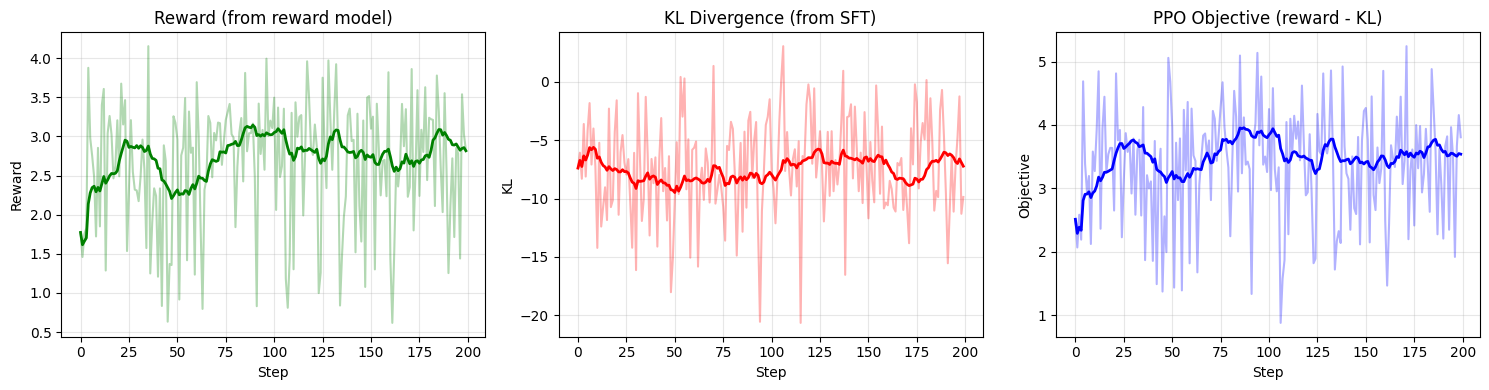

In [16]:
# Plot PPO training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

window = 20

for ax, data, title, color, ylabel in [
    (axes[0], ppo_rewards, 'Reward (from reward model)', 'green', 'Reward'),
    (axes[1], ppo_kls, 'KL Divergence (from SFT)', 'red', 'KL'),
    (axes[2], ppo_objectives, 'PPO Objective (reward - KL)', 'blue', 'Objective'),
]:
    ax.plot(data, alpha=0.3, color=color)
    smoothed = [sum(data[max(0,i-window):i+1])/min(i+1,window) for i in range(len(data))]
    ax.plot(smoothed, color=color, linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Results — SFT vs. RLHF

Let's compare the SFT model (before RL) with the RLHF-trained model (after RL). We'll look at both the generated text and the reward model's scores.

In [17]:
# Compare SFT vs RLHF outputs
test_prompts = [
    "Write a greeting",
    "Speak of love",
    "I am sad",
    "Give advice",
    "Tell me a story",
    "Describe the moon",  # unseen prompt
]

print("=" * 70)
print("SFT MODEL  vs  RLHF MODEL")
print("=" * 70)

sft_model.eval()
policy_model.eval()
reward_model.eval()

sft_rewards = []
rlhf_rewards = []

with torch.no_grad():
    for prompt in test_prompts:
        sft_response = chat(sft_model, prompt, max_tokens=35)
        rlhf_response = chat(policy_model, prompt, max_tokens=35)

        # Score both with reward model
        sft_tokens = torch.tensor([encode_for_reward(prompt, sft_response)], dtype=torch.long, device=device)
        rlhf_tokens = torch.tensor([encode_for_reward(prompt, rlhf_response)], dtype=torch.long, device=device)
        sft_score = reward_model(sft_tokens).item()
        rlhf_score = reward_model(rlhf_tokens).item()
        sft_rewards.append(sft_score)
        rlhf_rewards.append(rlhf_score)

        print(f"\nUser: {prompt}")
        print(f"  SFT:  (score={sft_score:+.3f}) {sft_response}")
        print(f"  RLHF: (score={rlhf_score:+.3f}) {rlhf_response}")
        print("-" * 70)

print(f"\nAverage reward: SFT={sum(sft_rewards)/len(sft_rewards):+.3f}, RLHF={sum(rlhf_rewards)/len(rlhf_rewards):+.3f}")

SFT MODEL  vs  RLHF MODEL

User: Write a greeting
  SFT:  (score=+4.236) or of mon world this hing to wis th
  RLHF: (score=-5.584) oood morrow to hee.
----------------------------------------------------------------------

User: Speak of love
  SFT:  (score=-4.925) ing his, bead froing sparthe sin th
  RLHF: (score=-5.151) oulow weild maRour of the is to mmm
----------------------------------------------------------------------

User: I am sad
  SFT:  (score=-5.606) ak, frove for mords dight smang the
  RLHF: (score=-5.575) ellivend with and forle wel; and mi
----------------------------------------------------------------------

User: Give advice
  SFT:  (score=-5.534) o heart, for sorrow fades ith the f
  RLHF: (score=-5.356) ommere for momerrow sises ande tilv
----------------------------------------------------------------------

User: Tell me a story
  SFT:  (score=-5.548) re is with werlch well thy tith.
  RLHF: (score=-5.528) om the the forrcos uprienck.
-----------------------

## Part 4: Reward Hacking

A key failure mode of RLHF: the model can learn to "hack" the reward model — generating outputs that score high but aren't actually good. This happens when the model exploits patterns in the reward model that don't correspond to real quality.

This is why the **KL penalty** is essential: it prevents the model from drifting too far from the SFT baseline. Without it, the model would quickly find degenerate solutions.

Let's see what happens with a very high KL beta vs. a very low one:

In [18]:
# Demonstrate the effect of KL penalty strength
print("The KL penalty controls how much the model can deviate from SFT:\n")
print(f"  beta=0.0  → No constraint, model can go wherever reward is highest")
print(f"             Risk: reward hacking (gibberish that scores high)")
print(f"  beta=0.1  → Moderate constraint (what we used)")
print(f"             Balance: improved quality while staying coherent")
print(f"  beta=10.0 → Very tight constraint")
print(f"             Risk: model barely changes from SFT")
print()
print("In practice, teams tune beta carefully. Too low → reward hacking.")
print("Too high → no improvement over SFT. This is one reason DPO")
print("(notebook 07) is popular — it avoids this tuning challenge.")

The KL penalty controls how much the model can deviate from SFT:

  beta=0.0  → No constraint, model can go wherever reward is highest
             Risk: reward hacking (gibberish that scores high)
  beta=0.1  → Moderate constraint (what we used)
             Balance: improved quality while staying coherent
  beta=10.0 → Very tight constraint
             Risk: model barely changes from SFT

In practice, teams tune beta carefully. Too low → reward hacking.
Too high → no improvement over SFT. This is one reason DPO
(notebook 07) is popular — it avoids this tuning challenge.


## Key Takeaways

**Reward Model:**
- Trained on preference pairs (chosen vs rejected) using Bradley-Terry loss
- Learns to score responses — higher score = better quality
- Same transformer architecture, but outputs a scalar instead of token predictions

**PPO:**
- Uses the reward model's scores as the training signal
- REINFORCE-style: generate → score → update policy toward higher reward
- KL penalty prevents the model from drifting too far from SFT

**Problems with RLHF:**
- **Complexity**: 4 models in memory (policy, reference, reward, value/critic)
- **Instability**: PPO is finicky — learning rate, KL beta, clipping all need tuning
- **Reward hacking**: the model can exploit the reward model's weaknesses
- **Expensive**: each training step requires generation + scoring + RL update

**This is why DPO was invented** (notebook 07): it achieves similar results with a single, stable loss function — no reward model, no PPO, no KL tuning.

### The RLHF pipeline in one picture

```
Pre-training → SFT → Reward Model → PPO → Final Model
  (language)   (format)  (scoring)   (quality)
```

### References
- [InstructGPT paper](https://arxiv.org/abs/2203.02155) — defined this pipeline
- [PPO paper](https://arxiv.org/abs/1707.06347) — the RL algorithm
- [Karpathy's Deep Dive into LLMs](https://www.youtube.com/watch?v=7xTGNNLPyMI) at ~2:30:00
- [RLHF in notebooks](https://github.com/ash80/RLHF_in_notebooks)